In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Effects of different loss functions for classification
In this jupyter notebook assignment, we will investigate the use of different methods to do binary classification and see how things work out. In particular, we will investigate four different approaches for learning classification boundaries:
1. Mean classification, i.e., calculating means of the labeled training data and classify based on distances from these means
2. Ordinary least squares, i.e., we calculate a best linear line that separates data based on standard squared loss
3. Exponential regression, i.e., we calculate a best linear line that separates data based on exponential loss
4. logistic regression, i.e., we calculate a best linear line that separates data based on logistic loss --- a "mellower" version of exponential loss that is less strict in penalizing "big" classification errors.

More details will be included while we go through the examples. 

The first thing that we will do is simply illustrate the losses 1,2,3 above so you can see how they look different. 


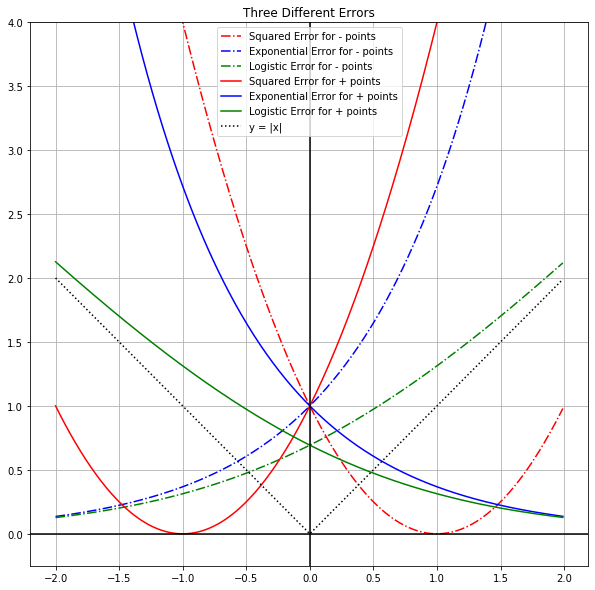

In [3]:
line_x = np.arange(-2, 2, 0.01)
squared_error = [(i-1)**2 for i in line_x]
squared_error_minus = [(i+1)**2 for i in line_x]
exp_error = np.exp(line_x)
exp_error_minus = np.exp(-line_x)
logistic_error = np.log(1+np.exp(line_x))
logistic_error_minus = np.log(1+np.exp(-line_x))
abs_val = np.abs(line_x)


fig, ax = plt.subplots(figsize = (10,10))
ax.grid(True, which='both')
plt.plot(line_x, squared_error, '-.', label='Squared Error for - points', color='r')
plt.plot(line_x, exp_error, '-.', label='Exponential Error for - points', color='b')
plt.plot(line_x, logistic_error, '-.', label='Logistic Error for - points', color='g')
plt.plot(line_x, squared_error_minus, label='Squared Error for + points', color='r')
plt.plot(line_x, exp_error_minus, label='Exponential Error for + points', color='b')
plt.plot(line_x, logistic_error_minus, label='Logistic Error for + points', color='g')
plt.plot(line_x, abs_val, ':', label='y = |x|', color='k')
plt.title('Three Different Errors')
plt.legend()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_ylim([-0.25,4])
plt.show()

In this plot, we plot out the error shapes for the $+1$ and $-1$ labeled classes. Notice that the logistic error approaches the plot of $y = |x|$ on one side and the exponential error on the other.

# Creating dataset

We generate a synthetic dataset by selecting red and blue points such that they lie approximately in a line.

For our different examples, we will be generating the training data in different ways to illustrate the capability of each approach in dealing with challenges. 

In [4]:
def random_generate_points(parameters, num_points, outlier_points, extreme_outlier_points, red = True, example4 = False):
    """
    Randomly generate points such that a large cluster lives at [1, a+b] for num_points-outlier_points points, and the rest lives on the line ax+b with noise.
    args:
        parameters: a length 3 list [a b sigma] that describes the underlying true linear line y = ax+b and the level of loss
        num_points: number of clustered data points near the true line
        outlier_points: number of non-clustered datapoints near the true line
        extreme_outlier_points: number of datapoints far from true line
        red: a boolean variable signaling if generated data points are red points (as opposed to blue points)
        example4: a boolean variable signaling if we are generating points for Example 4. 
    """
    a = parameters[0]
    b = parameters[1]
    sigma = parameters[2]
    
    x1 = np.random.uniform(0.8,1.2, size = [num_points,1])
    x2 = np.random.uniform(-5, 5, size = [outlier_points,1])
    x = np.concatenate((x1, x2))
    points = np.random.normal(a*x+b, sigma, size = [num_points+ outlier_points,1])
    out = np.concatenate((x,points),axis = 1)   
    x3 = np.random.uniform(2, 5, size = [extreme_outlier_points,1])
    
    if not example4:
        if red == True:
            extreme_points = np.random.normal(a*x3+b + 20, sigma, size = [extreme_outlier_points,1])
        else:
            x3 = np.random.uniform(-30, -25, size = [extreme_outlier_points,1])
            extreme_points = np.random.normal(a*x3+b - 50, sigma, size = [extreme_outlier_points,1])
        ext = np.concatenate((x3, extreme_points),axis = 1)

        out = np.concatenate((out, ext))

        return out
    else:
        x4 = np.random.uniform(10, 12, size = [extreme_outlier_points,1])
        if red == True:
            extreme_points = np.random.normal(a*x4+b, sigma, size = [extreme_outlier_points,1])
        else:
            extreme_points = np.random.normal(a*x4+b+30, 10*sigma, size = [extreme_outlier_points,1])
        ext = np.concatenate((x4, extreme_points),axis = 1)

        out = np.concatenate((out, ext))

        return out

# Example 1: Mean Classification

In this example, we showcase a simple example where mean classification performs nicely. 


(0, 2)

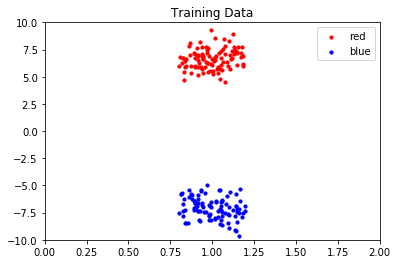

In [5]:
red_points_parameters = [2, 5, 1] # = [a,b,sigma], assuming y ~ ax+b 
blue_points_parameters = [-2, -5, 1]

num_points = 100

ar_red = random_generate_points(red_points_parameters, num_points, 0, 0)
ar_blue = random_generate_points(blue_points_parameters, num_points, 0, 0, red = False)

ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Training Data')
plt.legend()
ax.set_ylim([-10,10])
ax.set_xlim([0,2])

From this set of training data, we can calculate the means of the red and blue points.

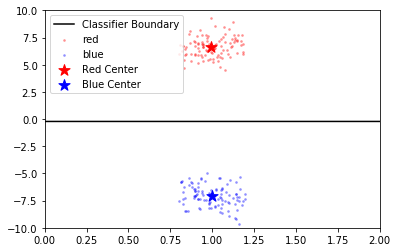

In [6]:
red_c = np.mean(ar_red, axis=0)
blue_c = np.mean(ar_blue, axis=0)
coeffs = red_c - blue_c
mid = (red_c + blue_c)/2.0

line_x = np.linspace(-5, 5)
line_y2 = [-(coeffs[0]/coeffs[1])*(i - mid[0]) + mid[1] for i in line_x]

ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=3, alpha = 0.3)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=3, alpha = 0.3)
plt.scatter(red_c[0], red_c[1], s=140, label='Red Center', marker='*', color='r')# facecolors='none', edgecolors='r')
plt.scatter(blue_c[0], blue_c[1], s=140, label='Blue Center', marker='*', color='b')# facecolors='none', edgecolors='r')
plt.plot(line_x, line_y2, label='Classifier Boundary', color='k')
plt.legend()
ax.set_ylim([-10,10])
ax.set_xlim([0,2])
plt.show()


# Example 2: Mean classification fails but ordinary least squares work

In the above example, we saw that mean classification works nicely when the underlying distribution and the data points are very nice behaving. In this example, we will see a case when mean classification fails but ordinary least squares work.

Again, we start by generating our training data.

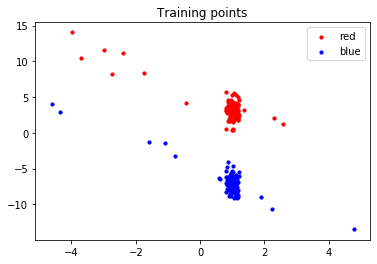

In [7]:
red_points_parameters = [-2, 5, 1] # = [a,b,sigma], assuming y ~ ax+b 
blue_points_parameters = [-2, -5, 1]

num_points = 100 # number of red or blue points
outlier_points = 10
extreme_outlier_points = 20

ar_red = random_generate_points(red_points_parameters, num_points, outlier_points, 0)
ar_blue = random_generate_points(blue_points_parameters, num_points, outlier_points, 0, red = False)

# Plot dataset
ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Training points')
plt.legend()

Now, we calculate the ordinary least squares classification boundary.

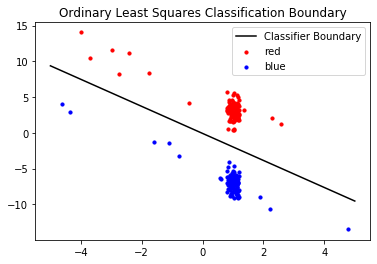

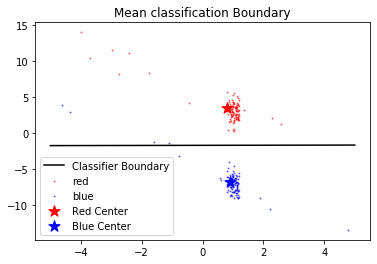

In [8]:
X = np.concatenate((ar_red, ar_blue))
n = len(X)

# Add column of ones to account for bias term
X = np.concatenate((X, np.ones((n,1))), axis=1)

# Create y array of class labels
y = np.concatenate((np.ones(int(n/2)), -np.ones(int(n/2))))

# Calculate the Ordinary Least Squares solution
beta = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Plot the resulting regression line
line_x = np.linspace(-5, 5)
# line_y = -beta[0] / beta[2] - (beta[1] / beta[2]) * line_x
line_y = -beta[0] / beta[1] * line_x - beta[2] / beta[1] 

# Plot dataset + centroid + classification
ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Ordinary Least Squares Classification Boundary')
plt.plot(line_x, line_y, label='Classifier Boundary', color='k')
plt.legend()
plt.show()

red_c = np.mean(ar_red, axis=0)
blue_c = np.mean(ar_blue, axis=0)
coeffs = red_c - blue_c
mid = (red_c + blue_c)/2.0
line_y2 = [-(coeffs[0]/coeffs[1])*(i - mid[0]) + mid[1] for i in line_x]

ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=1, alpha = 0.5)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=1, alpha = 0.5)
plt.scatter(red_c[0], red_c[1], s=140, label='Red Center', marker='*', color='r')# facecolors='none', edgecolors='r')
plt.scatter(blue_c[0], blue_c[1], s=140, label='Blue Center', marker='*', color='b')# facecolors='none', edgecolors='r')
plt.title('Mean classification Boundary')
plt.plot(line_x, line_y2, label='Classifier Boundary', color='k')
plt.legend()
plt.show()




As we can see, ordinary least squares works very well for this classification task but mean-based classification is making some mistakes.

# Example 3: Exponential regression

In this example, we will see an example where using exponential regression can be a good choice.

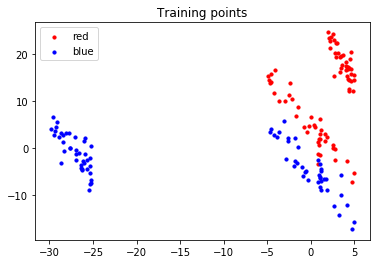

In [9]:
red_points_parameters = [-2, 5, 2] # = [a,b,sigma], assuming y ~ ax+b 
blue_points_parameters = [-2, -5, 2]

num_points = 10 # number of red or blue points
outlier_points = 30
extreme_outlier_points = 40

ar_red = random_generate_points(red_points_parameters, num_points, outlier_points, extreme_outlier_points)
ar_blue = random_generate_points(blue_points_parameters, num_points, outlier_points, extreme_outlier_points, red = False)

# Plot dataset
ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Training points')
plt.legend()

First, we calculate the ordinary least squares classification boundary.

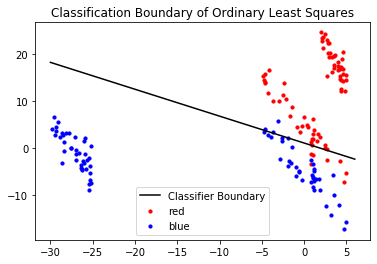

In [10]:
X = np.concatenate((ar_red, ar_blue))
n = len(X)

# Add column of ones to account for bias term
X = np.concatenate((X, np.ones((n,1))), axis=1)

# Create y array of class labels
y = np.concatenate((np.ones(int(n/2)), -np.ones(int(n/2))))

# Calculate the Ordinary Least Squares solution
beta = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Plot the resulting regression line
line_x = np.linspace(-30, 6)
# line_y = -beta[0] / beta[2] - (beta[1] / beta[2]) * line_x
line_y = -beta[0] / beta[1] * line_x - beta[2] / beta[1] 

# Plot dataset + classification
ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Classification Boundary of Ordinary Least Squares')
plt.plot(line_x, line_y, label='Classifier Boundary', color='k')
plt.legend()
plt.show()

Now, let's calculate our exponential regression boundary. To do this, we will be handcrafting an exponential regression where we use an exponential loss --- we want + points (red ones) to be positive and - points (blue ones) to be negative. More positive is better for + points and more negative is better for - points. This is done by applying $e^{-p}$ as the cost for points that should have a positive label and $e^{+p}$ as the cost for points that should have a negative label.

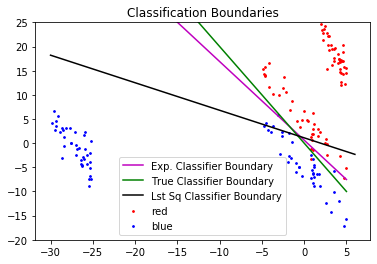

In [11]:
def update_weight_exponential(w, X0, X1):
    """
    Calculates the next weight for exponential regression
    args:
    w: current weight
    X0: red training data
    X1: blue training data
    """
    p0 = np.dot(X0,w)
    p1 = np.dot(X1,w)
    
    first_der0 = -np.exp(-p0)
    second_der0 = np.exp(p0)
    
    first_der1 = np.exp(p1)
    second_der1 = np.exp(p1)
    
    # Compute the new targets based on the first and second derivatives
    new_targets_0 = -np.divide(first_der0, np.sqrt(second_der0))
    new_targets_1 = -np.divide(first_der1, np.sqrt(second_der1))
    
    # reweight the X features to reflect what the second derivative tells us
    new_X0 = np.multiply(np.sqrt(second_der0), X0)
    new_X1 = np.multiply(np.sqrt(second_der1), X1)
    new_X = np.concatenate((new_X0, new_X1))
   
    # Join the targets together into one long vector.
    new_y = np.concatenate((new_targets_0, new_targets_1))
    
    # Now return the updated weight --- which is the old weight plus the least-squares solution for the new problem
    return w + np.linalg.inv(new_X.T @ new_X) @ (new_X.T @ new_y)
    
    
w = np.zeros((3,1))
concatenated_red = np.concatenate((ar_red, np.ones((ar_red.shape[0],1))), axis = 1)
concatenated_blue = np.concatenate((ar_blue, np.ones((ar_blue.shape[0],1))), axis = 1)

for i in range(1000):
    w = update_weight_exponential(w, concatenated_red, concatenated_blue)
    
def get_line_val(x, w):
    return (-w[0]/w[1]) * x - w[2] / w[1]
    
line_x_axis = np.arange(-30,6,1)
line_y_axis = [get_line_val(i, w) for i in line_x_axis]

true_y_axis = [red_points_parameters[0]*i + (red_points_parameters[1]+blue_points_parameters[1])/2 for i in line_x_axis]

ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=3)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=3)
plt.title('Classification Boundaries')
plt.plot(line_x_axis, line_y_axis, label='Exp. Classifier Boundary', color='m')
plt.plot(line_x_axis, true_y_axis, label='True Classifier Boundary', color='g')
plt.plot(line_x, line_y, label='Lst Sq Classifier Boundary', color='k')
ax.set_ylim([-20,25])
plt.legend()
plt.show()


# Example 4: Logistic Regression

In this example, we will handcraft a logistic regression and see examples where logistic regression performs better than exponential regression. Again, we start by generating training data.

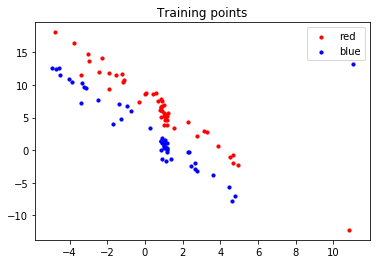

In [12]:
red_points_parameters = [-2, 8, 1] # = [a,b,sigma], assuming y ~ ax+b 
blue_points_parameters = [-2, 3, 1]

num_points = 20 # number of red or blue points
outlier_points = 30
extreme_outlier_points = 1

ar_red = random_generate_points(red_points_parameters, num_points, outlier_points, 
                                extreme_outlier_points, example4 = True)
ar_blue = random_generate_points(blue_points_parameters, num_points, outlier_points, 
                                 extreme_outlier_points, red = False, example4 = True)

# Plot dataset
ax = plt.subplot(111)
plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Training points')
plt.legend()

We get our weight estimations by using our weight updates.

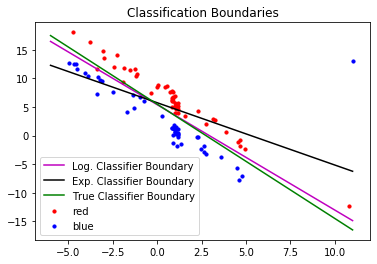

In [13]:

def update_weight_logistic(w, X0, X1):
    """
    Calculates the next weight for exponential regression
    args:
    w: current weight
    X0: red training data
    X1: blue training data
    """
    p0 = np.dot(X0,w)
    p1 = np.dot(X1,w)
    
    first_der0 = -np.divide(np.exp(-p0), (1.0+np.exp(-p0)))
    second_der0 = np.divide(np.exp(p0), ((1.0+np.exp(p0))**2))
    
    first_der1 = np.divide(np.exp(p1), (1.0+np.exp(p1)))
    second_der1 = np.divide(np.exp(p1), ((1.0+np.exp(p1))**2))
    
    new_targets_0 = -np.divide(first_der0, np.sqrt(second_der0))
    new_targets_1 = -np.divide(first_der1, np.sqrt(second_der1))
    
    new_X0 = np.multiply(np.sqrt(second_der0), X0)
    new_X1 = np.multiply(np.sqrt(second_der1), X1)
    
    new_X = np.concatenate((new_X0, new_X1))
    new_y = np.concatenate((new_targets_0, new_targets_1))
    
    return w + np.linalg.inv(new_X.T @ new_X) @ (new_X.T @ new_y)
    
    
w_log = np.zeros((3,1))
w_exp = np.zeros((3,1))
concatenated_red = np.concatenate((ar_red, np.ones((ar_red.shape[0],1))), axis = 1)
concatenated_blue = np.concatenate((ar_blue, np.ones((ar_blue.shape[0],1))), axis = 1)

for i in range(100):
    w_log = update_weight_logistic(w_log, concatenated_red, concatenated_blue)
    w_exp = update_weight_exponential(w_exp, concatenated_red, concatenated_blue)

line_x_axis = np.arange(-6,12,1)
line_y_axis_log = [get_line_val(i, w_log) for i in line_x_axis]
line_y_axis_exp = [get_line_val(i, w_exp) for i in line_x_axis]
true_y_axis = [red_points_parameters[0]*i + (red_points_parameters[1]+blue_points_parameters[1])/2 for i in line_x_axis]

plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title('Classification Boundaries')
plt.plot(line_x_axis, line_y_axis_log, label='Log. Classifier Boundary', color='m')
plt.plot(line_x_axis, line_y_axis_exp, label='Exp. Classifier Boundary', color='k')
plt.plot(line_x_axis, true_y_axis, label = 'True Classifier Boundary', color = 'g')
plt.legend()
plt.show()

As we can see, even with one mislabeled outlier we are able to shift the exponential classification boundary by a large amount. Meanwhile, logistic regression is indeed more mellow about this. This illustrates how logistic regression is not as sensitive to outliers as the exponential regression model.

Next, let's see how the classifier boundary changes for both exponential and logistic regression in each iteration. 

#### After you run the cell, go back to the homework PDF and answer Part (g) iii).

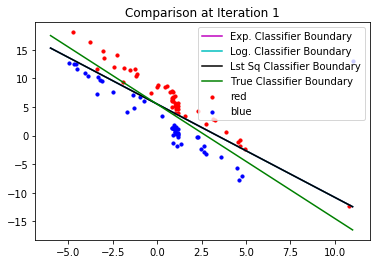

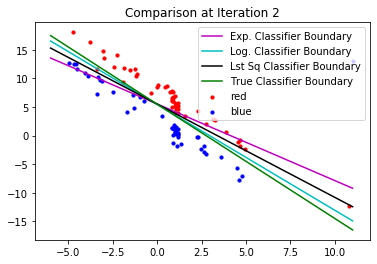

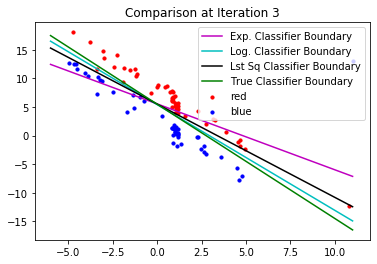

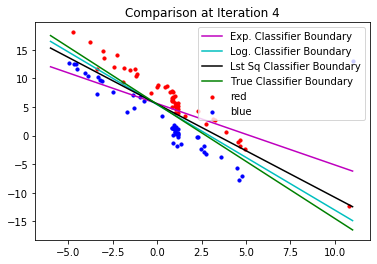

In [14]:
w_log = np.zeros((3,1))
w_exp = np.zeros((3,1))

X = np.concatenate((ar_red, ar_blue))
n = len(X)

# Add column of ones to account for bias term
X = np.concatenate((X, np.ones((n,1))), axis=1)

# Create y array of class labels
y = np.concatenate((np.ones(int(n/2)), -np.ones(int(n/2))))

# Calculate the Ordinary Least Squares solution
beta = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Plot the resulting regression line
line_y_LS = -beta[0] / beta[1] * line_x_axis - beta[2] / beta[1] 


for i in range(4):
    w_log = update_weight_logistic(w_log, concatenated_red, concatenated_blue)
    w_exp = update_weight_exponential(w_exp, concatenated_red, concatenated_blue)
    #print(w_log, w_exp)
    line_x_axis = np.arange(-6,12,1)
    line_y_axis_log = [get_line_val(i, w_log) for i in line_x_axis]
    line_y_axis_exp = [get_line_val(i, w_exp) for i in line_x_axis]
    true_y_axis = [red_points_parameters[0]*i + (red_points_parameters[1]+blue_points_parameters[1])/2 for i in line_x_axis]
    plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
    plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
    plt.title(f"Comparison at Iteration {i+1}")
    plt.plot(line_x_axis, line_y_axis_exp, label = 'Exp. Classifier Boundary', color = 'm')
    plt.plot(line_x_axis, line_y_axis_log, label = 'Log. Classifier Boundary', color = 'c')
    plt.plot(line_x_axis, line_y_LS, label = 'Lst Sq Classifier Boundary', color = 'k')
    plt.plot(line_x_axis, true_y_axis, label = 'True Classifier Boundary', color = 'g')
    plt.legend()
    plt.show()

This shows that the line is almost fixed after a very small number of iterations. These iterated least-squares approaches are very fast to converge in general. This is why in practice, logistic or exponential regression costs almost the same to run as ordinary least squares.

### Comparing with sklearn's logistic regression function
In this part we will see that our logistic regression gives the same solution as scikitlearn's logistic regression function.

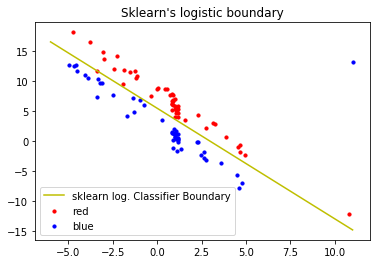

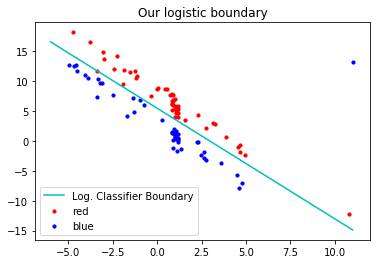

Function of sklearn boundary: 1.4145682585691788x + 0.7670155101320034y + -4.1518597015972745 = 0.
Function of our boundary: 1.4135280682798659x + 0.7663401605399697y + -4.148347740608763 = 0.


In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1000000.0, 
                         fit_intercept=False, intercept_scaling=1, class_weight=None, 
                         random_state=None, solver='lbfgs', max_iter=100, 
                         multi_class='warn', verbose=0, warm_start=False, n_jobs=None).fit(X, y)
coeffs = clf.coef_[0]
line_y_axis_sklearn = [get_line_val(i, coeffs) for i in line_x_axis]
line_y_axis_log = [get_line_val(i, w_log) for i in line_x_axis]

plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title(f"Sklearn's logistic boundary")
plt.plot(line_x_axis, line_y_axis_sklearn, label = 'sklearn log. Classifier Boundary', color = 'y')
plt.legend()
plt.show()

plt.scatter(ar_red[:,0], ar_red[:,1], label='red', color='r', s=10)
plt.scatter(ar_blue[:,0], ar_blue[:,1], label='blue', color='b', s=10)
plt.title(f"Our logistic boundary")
plt.plot(line_x_axis, line_y_axis_log, label = 'Log. Classifier Boundary', color = 'c')
plt.legend()
plt.show()

print(f"Function of sklearn boundary: {coeffs[0]}x + {coeffs[1]}y + {coeffs[2]} = 0.")
print(f"Function of our boundary: {w_log[0][0]}x + {w_log[1][0]}y + {w_log[2][0]} = 0.")


We can see that our logistic regression boundary is practically the same as sklearn's boundary, with very small numerical difference.